[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_dataset.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import os

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 1000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
execution_path = os.getcwd()

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [229]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average housing area" and "per housing area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df.drop(["OBJECTCAT"], axis=1)
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  
  # Convert all strings to numeric
  df = df.convert_objects(convert_numeric=True)
  
  # Remove rows containing a "0", i.e price = 0 or rooms = 0
  df = df[~(df[["PRICE", "ROOMS","AREA"]] == 0)]
  
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  return df

In [231]:
df = clean_data(source)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [232]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
1,595000.0,7.209542,9.0,440.0,3.889550
5,299000.0,7.666556,5.0,140.0,3.332205
6,685000.0,7.497003,8.0,380.0,3.860730
8,206000.0,6.600842,1.0,280.0,5.634790
9,75000.0,7.114370,3.0,61.0,3.012262


In [233]:
df.describe()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
count,1.281800e+05,128180.000000,128180.000000,128180.000000,128180.000000
mean,1.054886e+06,7.524109,5.187603,183.766251,3.452136
std,2.231478e+08,0.733975,5.268999,556.929503,0.426526
min,3.000000e+02,1.629641,1.000000,1.000000,0.000000
25%,1.390000e+05,7.130899,3.000000,87.000000,3.218876
50%,2.500000e+05,7.561682,4.000000,130.000000,3.394508
75%,4.250000e+05,7.963808,6.000000,200.000000,3.604138
max,7.987979e+10,20.960654,540.000000,84000.000000,9.903488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde18d4d0b8>]],
      dtype=object)

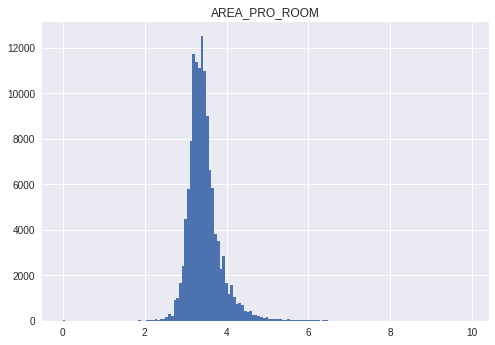

In [234]:
df.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde18d21b38>]],
      dtype=object)

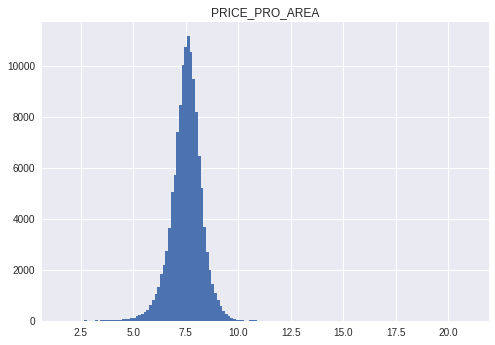

In [235]:
df.hist("PRICE_PRO_AREA", bins=BINS)

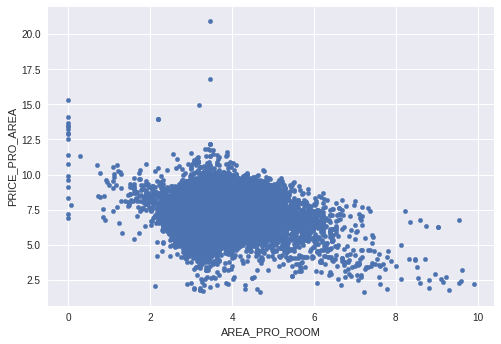

In [236]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [0]:
def create_dataset_files(df):
  """create all data-source files
  """
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  ds_train.to_csv(os.path.join(execution_path, "train.tsv"), sep="\t", header=False)
  
  ds_rest = df.drop(ds_train.index)
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  ds_eval.to_csv(os.path.join(execution_path, "eval.tsv"), sep="\t", header=False)
  
  ds_test = ds_rest.drop(ds_eval.index)
  
  ds_test.to_csv(os.path.join(execution_path, "test.tsv"), sep="\t", header=False) 

In [0]:
create_dataset_files(df)

In [0]:
TSV_COLUMNS = ['INDEX', 'PRICE', 'PRICE_PRO_AREA','ROOMS','AREA','AREA_PRO_ROOM']
DEFAULTS =    [[0.0],   [0.0],   [0.0],           [0.0],  [0.0], [0.0]          ]

In [0]:
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults = DEFAULTS, field_delim = "\t" )
      features = dict(zip(TSV_COLUMNS, columns))
      label = features.pop("PRICE_PRO_AREA")
      return features, label

    # Create list of file names that match "glob" pattern (i.e. data_file_*.csv)
    filenames_dataset = tf.data.Dataset.list_files(filename)
    # Read lines from text files
    textlines_dataset = filenames_dataset.flat_map(tf.data.TextLineDataset)
    # Parse text lines as comma-separated values (CSV)
    dataset = textlines_dataset.map(decode_csv)
    
    # Note:
    # use tf.data.Dataset.flat_map to apply one to many transformations (here: filename -> text lines)
    # use tf.data.Dataset.map      to apply one to one  transformations (here: text line -> feature list)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size = 10 * batch_size)
    else:
        num_epochs = 1 # end-of-input after this

    dataset = dataset.repeat(num_epochs).batch(batch_size)
    
    return dataset.make_one_shot_iterator().get_next()
  return _input_fn

In [0]:
def get_train():
  return read_dataset(os.path.join(execution_path, "train.tsv"), mode = tf.estimator.ModeKeys.TRAIN)

def get_eval():
  return read_dataset(os.path.join(execution_path, "eval.tsv"), mode = tf.estimator.ModeKeys.EVAL)

def get_test():
  return read_dataset(os.path.join(execution_path, "test.tsv"), mode = tf.estimator.ModeKeys.EVAL)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM") 
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [244]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpc2b2w5j5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde1b42b1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
for period in range(0, PERIODS):
  model.train(input_fn=get_train(), steps=STEPS)
  
  metrics_train = model.evaluate(steps=STEPS, input_fn=get_train())
  metrics_eval = model.evaluate(steps=STEPS, input_fn=get_eval()) 

  train_rmse = np.sqrt(metrics_train['average_loss'])
  eval_rmse = np.sqrt(metrics_eval['average_loss'])
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpc2b2w5j5/model.ckpt.
INFO:tensorflow:loss = 29583.336, step = 0
INFO:tensorflow:global_step/sec: 36.4701
INFO:tensorflow:loss = 29221.22, step = 100 (2.748 sec)
INFO:tensorflow:global_step/sec: 37.9469
INFO:tensorflow:loss = 29592.55, step = 200 (2.635 sec)
INFO:tensorflow:global_step/sec: 37.0668
INFO:tensorflow:loss = 29297.746, step = 300 (2.696 sec)
INFO:tensorflow:global_step/sec: 37.3099
INFO:tensorflow:loss = 29190.47, step = 400 (2.678 sec)
INFO:tensorflow:global_step/sec: 38.1357
INFO:tensorflow:loss = 28683.412, step = 500 (2.624 sec)
INFO:tensorflow:global_step/sec: 36.7837
INFO:tensorflow:loss = 29471.932, step = 600 (2.721 sec)
INFO:tensorflow:global_step/sec: 36.698
INFO:tensorflow:loss

In [0]:
test_predict = model.predict(input_fn=get_test())
metrics_test = model.evaluate(steps=STEPS, input_fn=get_test())
test_predict = np.array([item['predictions'][0] for item in test_predict])  
test_rmse = np.sqrt(metrics_test['average_loss'])
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

In [0]:
test_predict = np.array([item for item in test_predict])

In [0]:
test_predict